In [1]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import network
import torch.optim as optim
import os
from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import pandas as pd
import time
import data as dt

# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # for debugging on GPU
%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


torch.cuda.empty_cache()

Using cuda device


# Ball Tracker
## Dataset Creation

In [16]:
dataset_folder = 'cropped_classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
img_quant = 1
label_quant = 1
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=img_quant, label_quantization=label_quant, labels=['X', 'Y', 'Radius'])
# trainset_noquant = network.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True)
testset = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=img_quant, label_quantization=label_quant, labels=['X', 'Y', 'Radius'])
validationset = dt.BallTrackingDatasetImages(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=img_quant, label_quantization=label_quant, labels=['X', 'Y', 'Radius'])
batch_size = 50
trainloader = DataLoader(trainset_quant, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validationset, batch_size=batch_size, shuffle=True)
# img_shape_quant = trainset_quant.image_shape

Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 408, 680])
Label shape: (680, 408)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 408, 680])
Label shape: (680, 408)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 408, 680])
Label shape: (680, 408)


In [17]:
gen = dt.image_generator(trainset_quant)

408 680
max tensor(1.)
min tensor(0.)
Label:  tensor([252.,  89.,  47.])


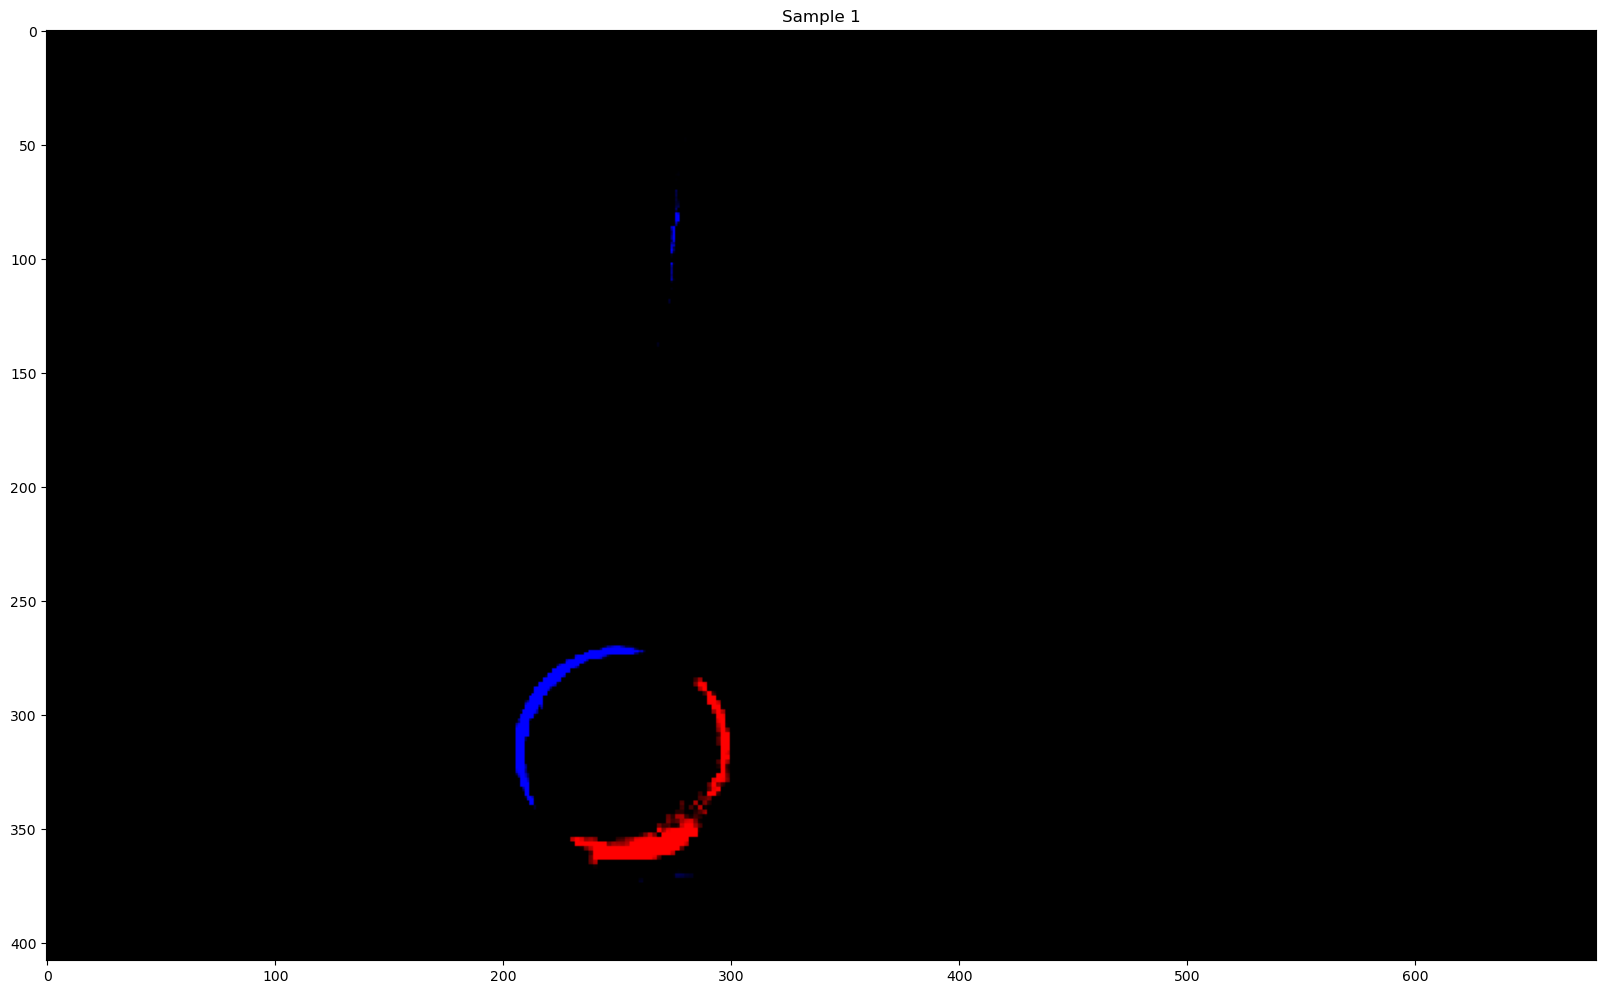

In [19]:
dt.show_next_img(gen, show_labels=False)

In [52]:
all_data = dt.BallTrackingDatasetImages(csv_path, image_dir, split='all', dataset_type="all", augment=True)

Loaded 1862 rows from classical_tracking_dataset\labels.csv
Final dataset split='all' size: 1862
Shape of the images: torch.Size([2, 408, 680])
Label shape: (680, 408)


In [225]:
all_data.create_cropped_dataset("cropped_classical_tracking_dataset")

Cropped dataset saved to cropped_classical_tracking_dataset


## Check the dataset

In [113]:
gen = dt.image_generator(testset)

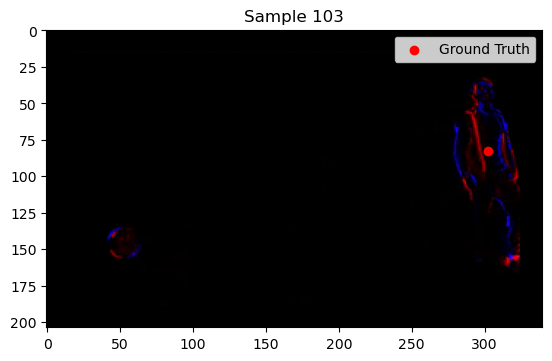

In [217]:
dt.show_next_img(gen)

## Model Training
### Classification

In [45]:
# Instantiate model
trainloader = trainloader
bins_factor = trainloader.dataset.quantization / trainloader.dataset.label_quantization
model = network.SCNN_Tracker2L(trainloader.dataset.image_shape, bins_factor).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Flattened feature size: 480


In [46]:
model.start_training(trainloader, optimizer, device, validationloader=validationloader, num_steps = 10, num_epochs=50)

torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([2, 3])
cuda:0 cuda:0
cuda:0 cuda:0
Epoch 1/50, Loss: 8.3744, Validation Error: 21.6685 pixels
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cuda:0
cuda:0 cuda:0
torch.Size([50, 3])
cuda:0 cud

KeyboardInterrupt: 

In [79]:
gen = dt.prediction_generator_classification(model, testset, bins_factor)

In [80]:
dt.show_next_img_w_pred(gen)

RuntimeError: Input type (double) and bias type (float) should be the same

### Regression

Flattened feature size: 3840
Epoch 1/50, Loss: 515.0574, Validation Error: 19.6771
Epoch 2/50, Loss: 339.6491, Validation Error: 9.1159
Epoch 3/50, Loss: 91.7180, Validation Error: 6.1373
Epoch 4/50, Loss: 41.0775, Validation Error: 4.1829
Epoch 5/50, Loss: 23.5369, Validation Error: 3.6533
Epoch 6/50, Loss: 14.9861, Validation Error: 2.8814
Epoch 7/50, Loss: 12.4920, Validation Error: 2.4276
Epoch 8/50, Loss: 8.4084, Validation Error: 2.4946
Epoch 9/50, Loss: 7.0192, Validation Error: 2.1060
Epoch 10/50, Loss: 5.8636, Validation Error: 1.9641
Epoch 11/50, Loss: 5.0319, Validation Error: 1.9323
Epoch 12/50, Loss: 5.0207, Validation Error: 1.8947
Epoch 13/50, Loss: 4.3129, Validation Error: 1.6348
Epoch 14/50, Loss: 3.9951, Validation Error: 1.6939
Epoch 15/50, Loss: 5.3877, Validation Error: 1.8353
Epoch 16/50, Loss: 5.7622, Validation Error: 1.8377
Epoch 17/50, Loss: 5.2084, Validation Error: 1.6794
Epoch 18/50, Loss: 4.0534, Validation Error: 1.6385
Epoch 19/50, Loss: 3.5658, Validat

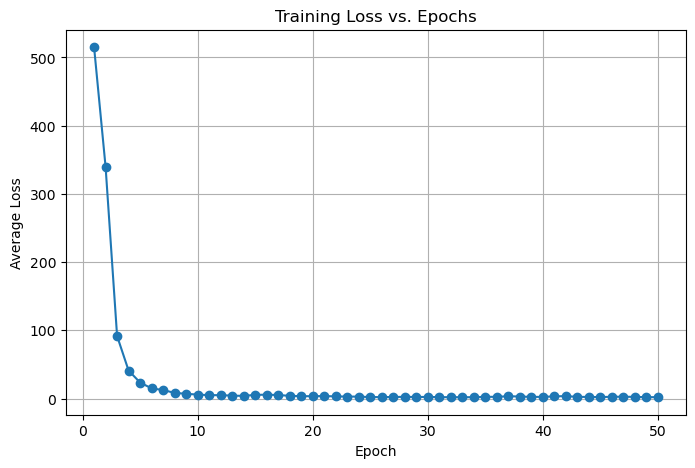

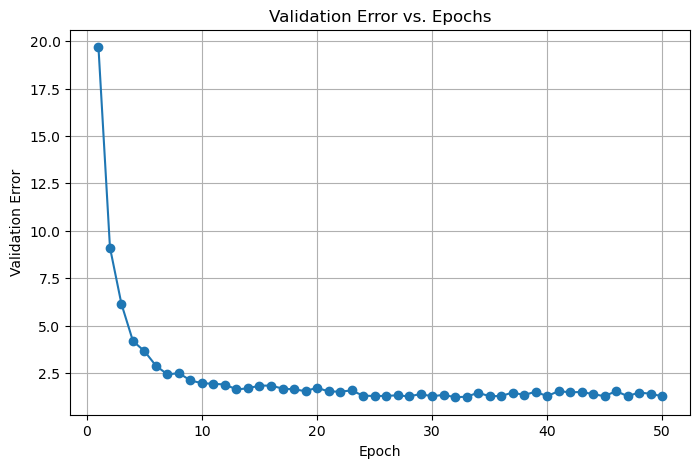

In [7]:
# Instantiate model
trainloader = trainloader
model = network.SCNN_TrackerRegression(trainloader.dataset.image_shape).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.start_training(trainloader, optimizer, device, validationloader=validationloader, num_steps = 100, num_epochs=50)

In [67]:
network.evaluate_regression_tracker(model, trainloader, device, num_steps=100)

Average X Error: 1.5539 pixels, Average Y Error: 0.8014 pixels


(1.553940565028089, 0.8013559174030385)

In [72]:
gen = dt.prediction_generator_regression(model, testset, device, num_steps=20)


In [73]:
dt.show_next_img_w_pred(gen)

RuntimeError: a Tensor with 340 elements cannot be converted to Scalar

In [25]:

model.start_training(trainloader, optimizer, device, num_steps = 100, num_epochs=10)

Epoch 1/10, Loss: 5.1855
Epoch 2/10, Loss: 5.8901
Epoch 3/10, Loss: 5.5490
Epoch 4/10, Loss: 5.1295


KeyboardInterrupt: 

In [14]:
bins_factor = trainloader.dataset.quantization / trainloader.dataset.label_quantization
model = network.SCNN_Tracker2L(trainloader.dataset.image_shape, bins_factor).to(device)

Flattened feature size: 480


In [ ]:
network.measure_inference_time_per_image(model, testloader, device, num_steps=20, num_batches=10)

Average inference time per image over 10 batches: 0.002313 seconds


0.002312630250000609

In [164]:
save_path = 'models/ball_tracker_quant8_20ts_20e.pt'
torch.save(model.state_dict(), save_path)

In [11]:
predictions = torch.tensor([[120.5, 300.3], [640.2, 500.1], [80.7, 250.6]])

# Ground truth labels (same shape as predictions)
labels = torch.tensor([[121.0, 299.0], [641.0, 501.0], [79.5, 252.0]])

# Define MSE Loss
criterion = nn.MSELoss()

# Compute loss
loss = criterion(predictions, labels)
print(loss.item())  # Output: MSE loss value

1.1316522359848022


In [ ]:
gen = dt.prediction_generator_classification(model, trainset_quant, device, num_steps=100)

In [15]:
error = network.evaluate_classification_tracker(model, testloader, device, num_steps=20)
np.linalg.norm(error).item()

Average X Error: 0.7284 pixels, Average Y Error: 0.5062 pixels


0.8870007381079535

Error at 1 timesteps: 19.322148085548683
Error at 6 timesteps: 6.6231408269245176
Error at 11 timesteps: 3.562044162430875
Error at 16 timesteps: 2.437108339703691
Error at 21 timesteps: 1.8957223704354842
Error at 26 timesteps: 1.670774257823206
Error at 31 timesteps: 1.4772005010492937
Error at 36 timesteps: 1.3814247689864454
Error at 41 timesteps: 1.3068763958280523
Error at 46 timesteps: 1.3058063730060099
Error at 51 timesteps: 1.247447534244434
Error at 56 timesteps: 1.2155068629731154
Error at 61 timesteps: 1.20816706778501
Error at 66 timesteps: 1.1932674227522073
Error at 71 timesteps: 1.18093729861072
Error at 76 timesteps: 1.1784437414153173
Error at 81 timesteps: 1.171791295135737
Error at 86 timesteps: 1.1655285218403229
Error at 91 timesteps: 1.1614556710261874
Error at 96 timesteps: 1.159635668121464


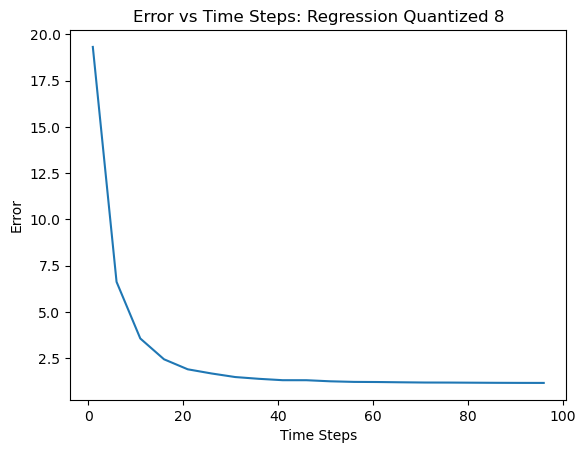

In [ ]:
network.plot_timestep_curve(model, testloader, device, identifier="Regression Quantized 8")

In [ ]:
table_path = "models/q4_results.csv"

df = pd.read_csv(table_path)
df

# Load Model

In [ ]:
quantization = 4
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=quantization)
testset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization)
img_shape_quant = trainset_quant.image_shape
model_name = 'ball_tracker_quant4_100.pt'
model = network.SCNN_Tracker3L(img_shape_quant, bins_factor=bins_factor).to(device)
model.load_state_dict(torch.load(os.path.join('models', model_name)))
gen = dt.prediction_generator_classification(model, trainset_quant, device, num_steps=200)

Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Flattened feature size: 16128
Number of x and y bins: 170, 102


C:\Users\realenriquem\AppData\Local\Temp\ipykernel_15368\4076664559.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('models

In [40]:
img, label = trainset_quant.__getitem__(0)
img = img.unsqueeze(0).to(device)

In [65]:

model(img, num_steps=20)

(tensor([[-19.2679, -19.2630, -17.9306, -19.2632, -19.2749, -17.7077, -14.0906,
          -21.7597, -16.4592, -19.3162, -19.1248, -18.5128, -15.9270, -14.9469,
          -18.2753, -18.0769, -16.0194, -14.5044, -16.1911, -19.4285, -20.7880,
          -21.4548, -16.8004, -15.1759, -21.6761, -15.8990, -23.2986, -14.3768,
          -16.3488, -17.1016, -18.2161, -19.3036, -21.2595, -16.8224, -18.0827,
          -18.3975, -14.4524, -17.0862, -16.1855, -18.8733, -17.3718, -15.8853,
          -20.2469, -17.5697, -18.0562, -13.8244, -16.2474, -15.8965, -18.7433,
          -12.5801, -12.9067, -14.3291, -12.3629, -13.0537, -12.2216,  -8.7523,
          -11.4359,  -6.5422,  -8.9536,  -8.7140, -16.9492, -10.0706,  -7.1211,
           -7.6305,  -5.5648,  -6.1765,  -7.4244,  -4.7954, -11.7020,  -3.8760,
           -2.9730,  -2.6448,  -4.1206,  -6.0435,  -5.9538,  -4.9591,  -6.3491,
           -8.0063,  -8.9986, -10.1586,  -7.6769, -10.5700,  -8.2896, -12.0432,
          -12.0017, -15.6418, -14.5777, 

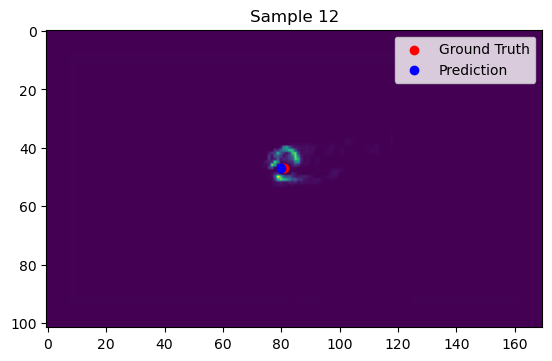

In [222]:
show_next_img_w_pred(gen)

Average X Error: 17.8210 pixels, Average Y Error: 9.2284 pixels
Error at 1 timesteps: 20.06865407521875
Average X Error: 17.1420 pixels, Average Y Error: 8.8889 pixels
Error at 6 timesteps: 19.3095743909881
Average X Error: 14.0864 pixels, Average Y Error: 3.0123 pixels
Error at 11 timesteps: 14.404910549878732
Average X Error: 0.9506 pixels, Average Y Error: 0.6049 pixels
Error at 16 timesteps: 1.1267757243560135
Average X Error: 0.9074 pixels, Average Y Error: 0.5185 pixels
Error at 21 timesteps: 1.0451074858905527
Average X Error: 0.8457 pixels, Average Y Error: 0.5617 pixels
Error at 26 timesteps: 1.0152397656418843
Average X Error: 0.8395 pixels, Average Y Error: 0.5617 pixels
Error at 31 timesteps: 1.0101036600538877
Average X Error: 0.8272 pixels, Average Y Error: 0.5494 pixels
Error at 36 timesteps: 0.9929833086422896
Average X Error: 0.8580 pixels, Average Y Error: 0.5247 pixels
Error at 41 timesteps: 1.0057372381322214
Average X Error: 0.8395 pixels, Average Y Error: 0.5679 p

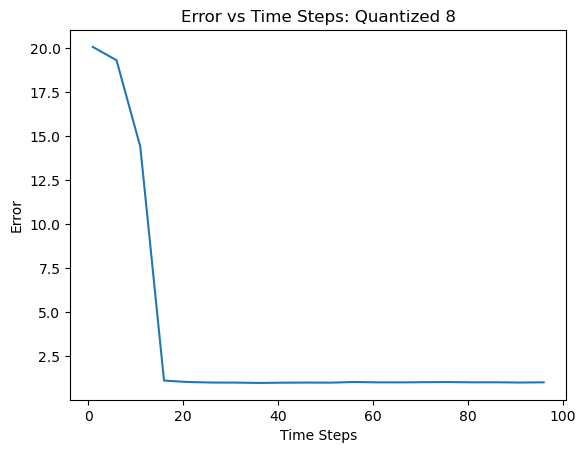

In [ ]:
testloader = DataLoader(testset_quant, batch_size=batch_size, shuffle=True)
network.plot_timestep_curve(model, testloader, device, identifier="Quantized 8")

In [97]:
img, label = trainset_quant.__getitem__(0)


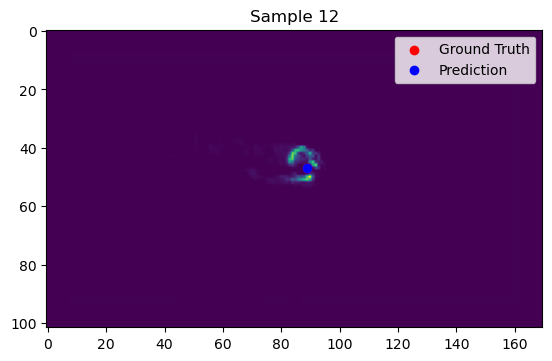

In [118]:
show_next_img_w_pred(gen)

# Polar Coordinates

Label:  tensor([280.,  71.,  50.])
680.0 408.0


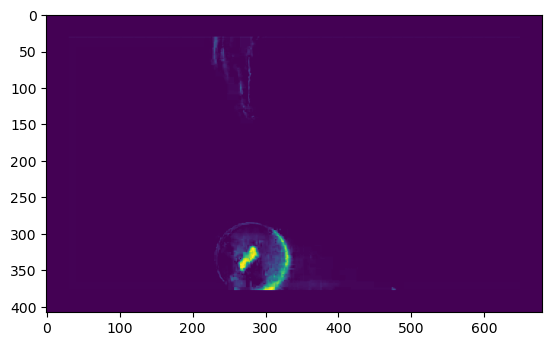

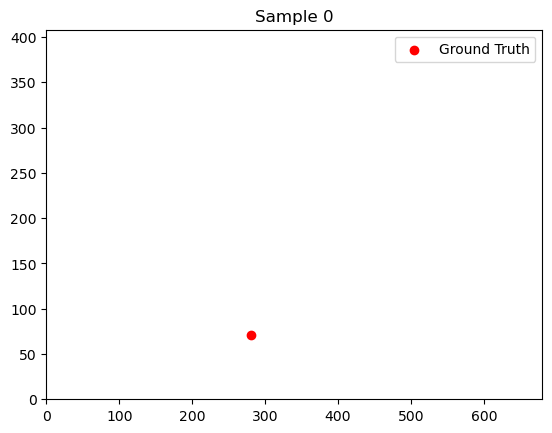

In [ ]:
gen = dt.image_generator(trainset_quant)
dt.show_next_img_separate(gen, quantization=4, label_quantization=4)

In [112]:
# Add a channel with all zeros to the image
def add_channel(img):
    zeros = torch.zeros_like(img[0])
    return torch.cat([img[0].unsqueeze(0), zeros.unsqueeze(0), img[1].unsqueeze(0)], dim=0)
add_channel(img).shape

torch.Size([3, 51, 85])

255


C:\Users\realenriquem\AppData\Local\Temp\ipykernel_15368\1502086338.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


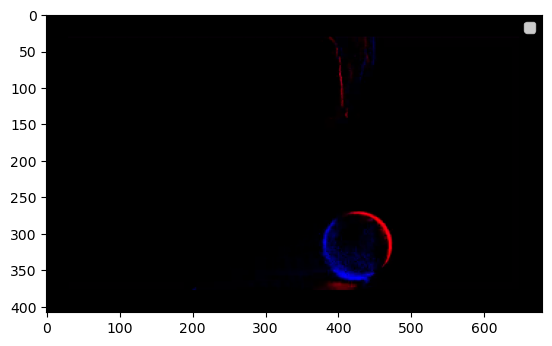

In [ ]:

idx, img, label, height, width = next(gen)
zeros = torch.zeros_like(img[0])
img = torch.cat([img[0].unsqueeze(0), zeros.unsqueeze(0), img[1].unsqueeze(0)], dim=0)
img_np = (img.cpu().numpy().transpose((1,2,0))*255).astype(np.uint8)
print(max(img_np.flatten()))
plt.figure()
plt.imshow(img_np, cmap='gray')
plt.legend()
plt.show()

In [181]:
img, label = trainset_quant.__getitem__(1)
image_np = img.numpy().transpose((1, 2, 0))
print(max(image_np.flatten()))
# add channel of all 0s
image_np = np.concatenate((image_np, np.zeros((image_np.shape[0], image_np.shape[1], 1))), axis=2)
print(max(image_np.flatten()))
image_np = (image_np * 255)
print(max(image_np.flatten()))

0.003921569
0.003921568859368563
1.0000000591389835


In [89]:
max(image_np.flatten())

np.uint8(0)

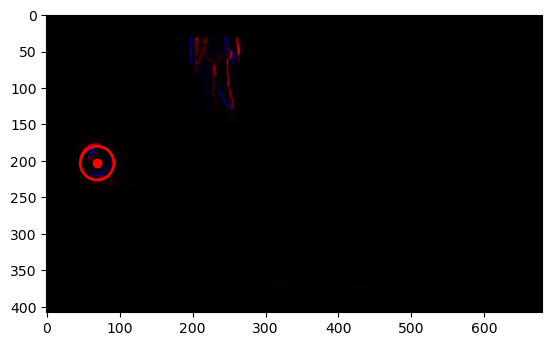

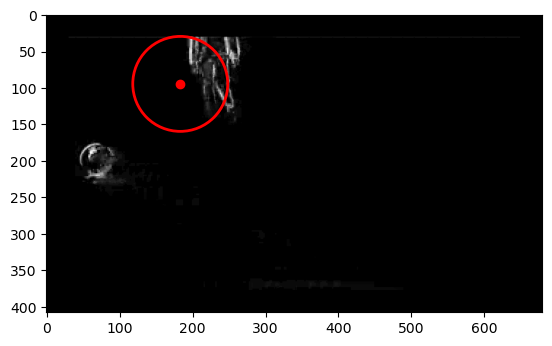

In [ ]:

# Show the image
# print(image_np.shape) 
idx, img, label, height, width = next(gen)
zeros = torch.zeros_like(img[0])
img = torch.cat([img[0].unsqueeze(0), zeros.unsqueeze(0), img[1].unsqueeze(0)], dim=0)
img_np = (img.cpu().numpy().transpose((1,2,0))*255).astype(np.uint8)
plt.figure()
plt.imshow(img_np, cmap='gray')  # Assuming img[1] is the correct visualization
plt.scatter(label[0], height - label[1], c='r', label="Ground Truth")
# Draw a circle around the label point with radius label[2]
circle = plt.Circle((label[0], height - label[1]), label[2], color='r', fill=False, linewidth=2)
plt.gca().add_patch(circle)  # Add the circle to the plot
image_gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
ht, wd = image_gray.shape[:2]
# scale = 360/ht
# dim = (int(scale*wd), 360)
# img_resize = cv2.resize(image_gray, dim)
# Enhance contrast using CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
contrast = clahe.apply(image_gray)
_, bin_img = cv2.threshold(contrast, 50, 255, cv2.THRESH_BINARY)
moments = cv2.moments(bin_img)
cx_resize = moments['m10']/moments['m00']
cy_resize = moments['m01']/moments['m00']
ht_resize, wd_resize = contrast.shape[:2]

h, w = contrast.shape[:2]
max_radius = min([h, w])//2
# M = w / log(radius)
img_polar = cv2.linearPolar(contrast, (cx_resize,cy_resize), max_radius, cv2.WARP_FILL_OUTLIERS)
r_circle_polar = img_polar.argmax(axis=1).mean()


# Convert r_circle to pixels
r_circle = r_circle_polar * max_radius / w

# Plot the circle in the original image
plt.figure()
plt.imshow(contrast, cmap='gray')
plt.scatter(cx_resize, cy_resize, c='r')
circle = plt.Circle((cx_resize, cy_resize), r_circle, color='r', fill=False, linewidth=2)
plt.gca().add_patch(circle)  # Add the circle to the plot

# Spikes

In [ ]:
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

In [82]:
spikes_x, spikes_y, mem_x, mem_y = spikes
# Plot spikes X


In [83]:
# neuron_idx = 0
spikes_x_np = np.empty((num_steps, width))
for step, spikes_step in enumerate(spikes_x):
    spikes_np_step = spikes_step.cpu().detach().numpy()
    spikes_x_np[step] = spikes_np_step
    

In [84]:
for neuron_idx in range(num_steps):
    spikes_neuron = spikes_x_np[:, neuron_idx]
    n_spikes = np.sum(spikes_neuron)
    print(n_spikes)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
18.0
0.0
0.0
0.0
0.0
0.0
5.0
0.0
11.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
19.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
44.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


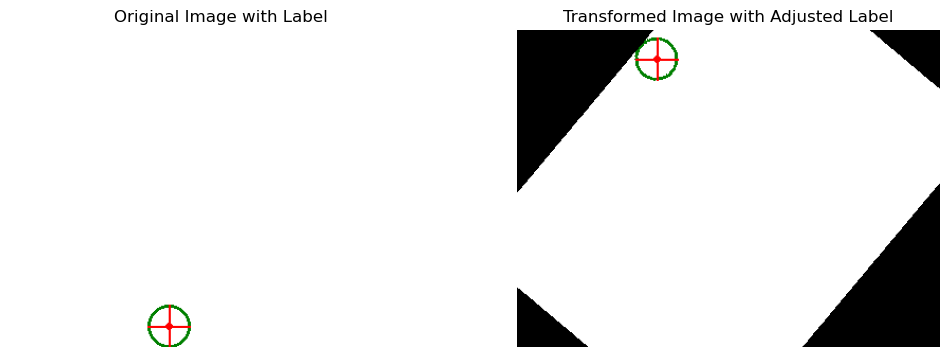

In [ ]:
import torchvision.transforms.functional as TF
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

# Create a blank test image (white background)
width, height = 400, 300
image = Image.new("RGB", (width, height), color="white")

# Define the original ball parameters (position and radius)
orig_x, orig_y, r = 150, 20, 20
r_dot = 3

minus_y = height - orig_y
# Create a copy of the image and draw the original ball label on it
original_with_circle = image.copy()
draw_circle = ImageDraw.Draw(original_with_circle)
draw_circle.ellipse((orig_x - r, minus_y - r, orig_x + r, minus_y + r), outline="green", width=3)

original_with_label = original_with_circle.copy()
draw_orig = ImageDraw.Draw(original_with_label)
draw_orig.ellipse((orig_x - r_dot, minus_y - r_dot, orig_x + r_dot, minus_y + r_dot), outline="red", width=3)
# Horizontal line
draw_orig.line(
    [(orig_x - r, minus_y), (orig_x + r, minus_y)],
    fill="red",
    width=2
)

# Vertical line
draw_orig.line(
    [(orig_x, minus_y - r), (orig_x, minus_y + r)],
    fill="red",
    width=2
)

# Set transformation parameters (for testing, we fix these values)
do_hflip = True
do_vflip = True
angle = 50  # degrees rotation

# Copy the original image for transformation
transformed = original_with_circle.copy()

# We'll also start with the original label coordinates
x, y = orig_x, orig_y

# Apply horizontal flip if enabled and update x-coordinate accordingly.
if do_hflip:
    transformed = TF.hflip(transformed)
    x = transformed.width - x

# Apply vertical flip if enabled and update y-coordinate accordingly.
if do_vflip:
    transformed = TF.vflip(transformed)
    y = transformed.height - y

# Rotate the image by the specified angle.
transformed = TF.rotate(transformed, angle)

# Adjust the label coordinates for the rotation.
# We rotate the point (x, y) around the center of the image.
cx, cy = transformed.width / 2, transformed.height / 2
angle_rad = math.radians(angle)
# print(angle_rad/np.pi)
# print(math.cos(angle_rad))
# print(math.sin(angle_rad))
x_new = math.cos(angle_rad) * (x - cx) - math.sin(angle_rad) * (y - cy) + cx # CAREFUL WITH THIS!! Y axis is inverted in images
y_new = math.sin(angle_rad) * (x - cx) + math.cos(angle_rad) * (y - cy) + cy
x, y = x_new, y_new

minus_y = transformed.height - y

# Draw the adjusted label on the transformed image.
transformed_with_label = transformed.copy()
draw_trans = ImageDraw.Draw(transformed_with_label)
draw_trans.ellipse((x - r_dot, minus_y - r_dot, x + r_dot, minus_y + r_dot), outline="red", width=3)
# Horizontal
draw_trans.line(
    [(x - r, minus_y), (x + r, minus_y)],
    fill="red",
    width=2
)
# Vertical
draw_trans.line(
    [(x, minus_y - r), (x, minus_y + r)],
    fill="red",
    width=2
)
# r_circle = np.sqrt((orig_x-cx)**2 + (orig_y-cy)**2)
# draw_trans.ellipse((cx - r_circle, cy - r_circle, cx + r_circle, cy + r_circle), outline="blue", width=3)
# print(orig_x, orig_y)
# print(x, y)

# Plot the original and transformed images side by side.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_with_label)
axs[0].set_title("Original Image with Label")
axs[0].axis("off")
axs[1].imshow(transformed_with_label)
axs[1].set_title("Transformed Image with Adjusted Label")
axs[1].axis("off")
plt.show()


# Latency

In [34]:
in_img, label = trainset.__getitem__(2)
in_img = in_img.unsqueeze(0).to(device)
num_steps = 100

In [40]:
model2l = network.SCNN_Tracker2L(num_x_bins=680, num_y_bins=408).to(device)
model2l(in_img, num_steps)


Flattened feature size: 33600


(tensor([[0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015

In [ ]:
model3l = network.SCNN_Tracker3L(num_x_bins=680, num_y_bins=408).to(device)


Flattened feature size: 3840


(tensor([[0.0015, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0015,
          0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015

In [45]:
model3l(in_img, num_steps)

(tensor([[0.0015, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0015,
          0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015

In [11]:
# Train several models
dataset_folder = 'classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
batch_size = 50
quantization = 2
# all_num_steps = [20, 100]
print(f"TRAINING MODELS WITH QUANTIZATION {quantization}")
print("-"*50)
print("CREATING DATALOADERS")
print("-"*50)
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=quantization)
testset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization)
evalset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=quantization)
trainloader = DataLoader(trainset_quant, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset_quant, batch_size=batch_size, shuffle=True)
evalloader = DataLoader(evalset_quant, batch_size=batch_size, shuffle=True)
inferenceloader = DataLoader(testset_quant, batch_size=1, shuffle=False)
img_shape_quant = trainset_quant.image_shape
bins_factor = trainset_quant.quantization / trainset_quant.label_quantization
models_numsteps = [
    (network.SCNN_Tracker2L(img_shape_quant, bins_factor=bins_factor), 20),
    (network.SCNN_Tracker2L(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN_Tracker3L(img_shape_quant, bins_factor=bins_factor), 20),
    (network.SCNN_Tracker3L(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN_TrackerRegression(img_shape_quant), 20),
    (network.SCNN_TrackerRegression(img_shape_quant), 100),
]
df = pd.DataFrame(columns=['Model', 'Num Steps', 'Error', 'Inference Time', 'Training Time'])

print("-"*50)
print("TRAINING MODELS")
print("-"*50)

for model, num_steps in models_numsteps:
    model_type = model.model_type
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training model {model_type} with {num_steps} time steps")
    num_epochs = 25 if num_steps == 100 else 50
    print(f"Training for {num_epochs} epochs")
    model.to(device)
    start_train_time = time.perf_counter()
    model.start_training(trainloader, optimizer, device, 
                         validationloader=evalloader, 
                         num_steps=num_steps, num_epochs=num_epochs, plot=False)
    training_time = time.perf_counter() - start_train_time
    save_path = f'models/{model_type}_q{quantization}_{num_steps}ts_{num_epochs}e.pt'
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_params': model.training_params,
    }, save_path)
    error = model.evaluate(testloader, device, num_steps=20, print_results=False) # I am evaluating all models with 20 time steps for better comparison
    error = np.linalg.norm(error).item()
    inference_time = network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=num_steps, num_batches=5)

    new_row = pd.DataFrame({
        'Model': [model_type],
        'Num Steps': [num_steps],
        'Error': [error],
        'Inference Time': [inference_time],
        'Training Time': [training_time]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    print(f"Model {model_type} with {num_steps} time steps: Error={error:.4f}, Inference Time={inference_time:.6f} sec/image, Training Time={training_time:.2f} sec")
    print("-"*50)
    del model
    torch.cuda.empty_cache()
    

df.to_csv(f'models/q{quantization}_results.csv', index=False)

TRAINING MODELS WITH QUANTIZATION 2
--------------------------------------------------
CREATING DATALOADERS
--------------------------------------------------
Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 204, 340])
Label shape: (340, 204)
Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 204, 340])
Label shape: (340, 204)
Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 204, 340])
Label shape: (340, 204)
Flattened feature size: 8736
Flattened f

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_19384\3984922709.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Epoch 1/25, Loss: 11.1470, Validation Error: 25.0551 pixels
Epoch 2/25, Loss: 11.1455, Validation Error: 9.4835 pixels
Epoch 3/25, Loss: 11.1101, Validation Error: 8.9400 pixels
Epoch 4/25, Loss: 10.9820, Validation Error: 8.5852 pixels
Epoch 5/25, Loss: 10.8511, Validation Error: 7.0335 pixels
Epoch 6/25, Loss: 10.8083, Validation Error: 6.3368 pixels
Epoch 7/25, Loss: 10.7380, Validation Error: 6.0308 pixels
Epoch 8/25, Loss: 10.6706, Validation Error: 5.9078 pixels
Epoch 9/25, Loss: 10.6408, Validation Error: 5.5205 pixels
Epoch 10/25, Loss: 10.6317, Validation Error: 5.6249 pixels
Epoch 11/25, Loss: 10.5391, Validation Error: 5.7439 pixels
Epoch 12/25, Loss: 10.4847, Validation Error: 5.3569 pixels
Epoch 13/25, Loss: 10.5473, Validation Error: 5.2792 pixels
Epoch 14/25, Loss: 10.5039, Validation Error: 5.1717 pixels
Epoch 15/25, Loss: 10.5311, Validation Error: 4.9882 pixels
Epoch 16/25, Loss: 10.4745, Validation Error: 4.7024 pixels
Epoch 17/25, Loss: 10.4618, Validation Error: 4.

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [12]:
df

Model Num Steps     Error  Inference Time  Training Time
0  Tracker2L        20  4.011173        0.034387     461.522792
1  Tracker2L       100  4.604231        0.169417    3898.890472
2  Tracker3L        20  2.566899        0.045072   13002.024764

In [4]:
model = network.load_model("models/Tracker3L_q2_20ts_50e.pt", network.SCNN_Tracker3L, device)
# network.evaluate_classification_tracker(model, testloader, device, num_steps=20, operation='distribution')

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Flattened feature size: 67200
Number of x and y bins: 340, 204


In [32]:
img_quant = 8
label_quant = 8
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=img_quant, label_quantization=label_quant)
testset = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=img_quant, label_quantization=label_quant)
validationset = dt.BallTrackingDatasetImages(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=img_quant, label_quantization=label_quant)
batch_size = 50
trainloader = DataLoader(trainset_quant, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validationset, batch_size=batch_size, shuffle=True)
inferenceloader = DataLoader(testset, batch_size=1, shuffle=True)
image_shape_quant = trainset_quant.image_shape

Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)


In [33]:
checkpoint = torch.load('models/Tracker3L_q8_20ts_50e.pt')
checkpoint['training_params']['image_shape'] = image_shape_quant
bins_factor = checkpoint['training_params']['quantization']/checkpoint['training_params']['label_quantization']
# Create model instance with the same parameters as the saved model
model =  network.SCNN_Tracker3L(image_shape_quant, bins_factor=bins_factor)
model.load_state_dict(checkpoint['model_state_dict'])
model.training_params = checkpoint['training_params']
model.to(device)

network.save_model(model)

Flattened feature size: 3840
Number of x and y bins: 85, 51
Model saved at models/Tracker3L_q8_20ts_50e.pt


C:\Users\realenriquem\AppData\Local\Temp\ipykernel_7512\3284168380.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/Tracker3L_q8_20ts_50e.

In [60]:
quantization = 8
testset = dt.BallTrackingDatasetImages(csv_path, image_dir, 'ball', 'val', quantization=quantization)
inferenceloader = DataLoader(testset, batch_size=1, shuffle=True)
model = network.load_model('models/Tracker3L_q8_20ts_50e.pt', network.SCNN_Tracker3L, device)
network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=20, num_batches=100)

Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Flattened feature size: 3840
Number of x and y bins: 85, 51
Average inference time per image over 100 batches: 0.042875 seconds


0.04287484600012249

In [ ]:
quantization = 4

testset = dt.BallTrackingDatasetImages(csv_path, image_dir, 'ball', 'val', quantization=quantization)
inferenceloader = DataLoader(testset, batch_size=1, shuffle=True)
model = network.load_model('models/Tracker3L_q4_20ts_50e.pt', network.SCNN_Tracker3L, device)
network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=20, num_batches=100)

Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Flattened feature size: 16128
Number of x and y bins: 170, 102


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average inference time per image over 100 batches: 0.043848 seconds


0.04384812000054808

In [7]:
quantization = 2
testset = dt.BallTrackingDatasetImages(csv_path, image_dir, 'ball', 'val', quantization=quantization)
inferenceloader = DataLoader(testset, batch_size=1, shuffle=True)
model = network.load_model('models/Tracker3L_q2_20ts_50e.pt', network.SCNN_Tracker3L, device)
network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=20, num_batches=100)

Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 204, 340])
Label shape: (340, 204)


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Flattened feature size: 67200
Number of x and y bins: 340, 204
Average inference time per image over 100 batches: 0.040132 seconds


0.040131928000000275

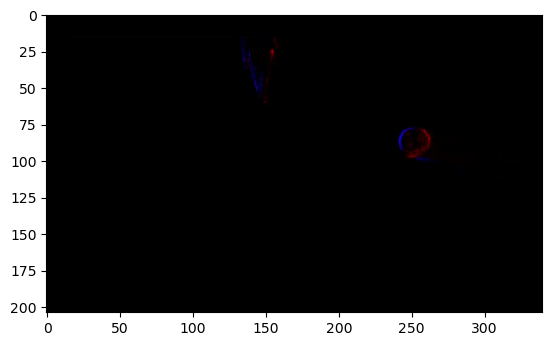

In [6]:
img, label = testset.__getitem__(0)
img = dt.tensor_to_image(img)
plt.imshow(img, cmap='gray')

In [70]:
network.save_model(model)

Model saved at models/Tracker3L_q2_20ts_50e.pt


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Flattened feature size: 16128
Number of x and y bins: 170, 102
X errors: μ=1.07, σ=1.02, 95% CI=2.745 pixels
Y errors: μ=0.78, σ=1.11, 95% CI=2.609 pixels
Total errors: σ=1.42, 95% CI=3.475 pixels


(array([2., 0., 1., 2., 0., 0., 1., 1., 0., 1., 3., 0., 0., 1., 1., 5., 1.,
        0., 0., 2., 0., 1., 2., 1., 1., 1., 1., 1., 1., 2., 3., 0., 1., 1.,
        2., 2., 2., 0., 0., 6., 1., 0., 3., 1., 2., 0., 3., 2., 0., 0., 0.,
        0., 1., 1., 2., 1., 1., 2., 2., 2., 1., 0., 0., 1., 2., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 2., 1., 2., 1., 0., 0., 1., 1., 1., 1., 1.,
        0., 1., 2., 1., 2., 1., 0., 1., 0., 2., 1., 1., 1., 1., 1., 0., 0.,
        1., 2., 0., 0., 3., 1., 2., 0., 0., 0., 1., 1., 2., 1., 2., 1., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 3., 3., 2., 1., 1., 1.,
        2., 1., 0., 2., 0., 1., 2., 3., 1., 0., 1., 4., 1., 2., 3., 1., 0.,
        2., 1., 2., 1., 0., 2., 0., 1., 0.]),
 array([0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 2., 2., 0., 5., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 1., 3., 0., 4., 0.,
        2., 2., 0., 1., 2., 6., 0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 2., 2., 1.

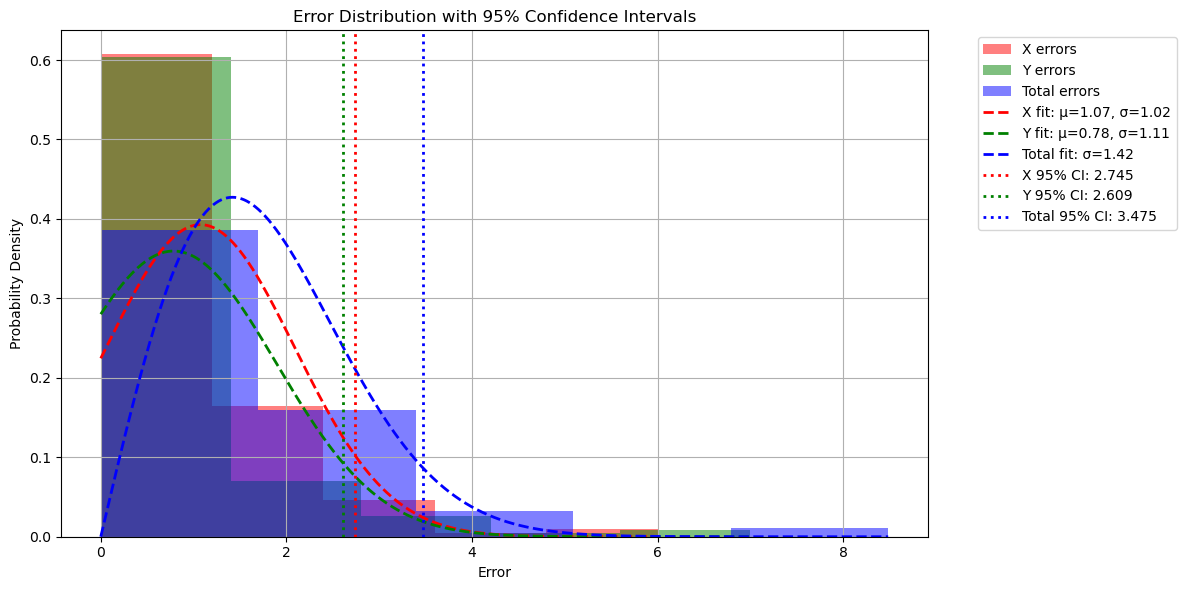

In [ ]:
model = network.load_model("models/Tracker3L_q4_20ts_50e.pt", network.SCNN_Tracker3L, device)
network.evaluate_classification_tracker(model, testloader, device, num_steps=20, operation='distribution')

In [14]:
quantization = 8
testset = dt.BallTrackingDatasetImages(csv_path, image_dir, 'ball', 'val', quantization=quantization)

Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)


In [15]:
model = network.load_model("models/Tracker3L_q8_20ts_50e.pt", network.SCNN_Tracker3L, device)


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Flattened feature size: 3840
Number of x and y bins: 85, 51


In [16]:
gen = dt.prediction_generator_classification(model, testset, device, num_steps=20)


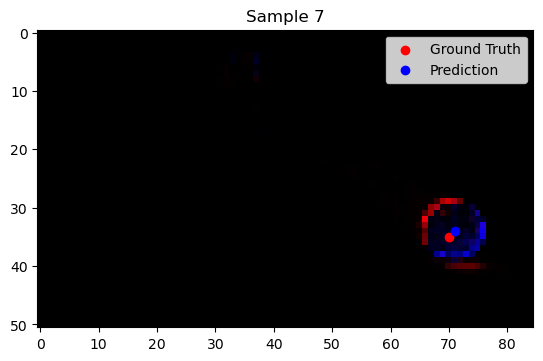

In [24]:
dt.show_next_img_w_pred(gen)

In [30]:
quantization = 4
trainset = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=quantization)
testset = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization)
batch_size = 50
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(trainloader))

Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)


Flattened feature size: 16128
Number of x and y bins: 170, 102
Epoch 1/50, Loss: 2068.4237, Validation Error: 38.7778 pixels
Epoch 2/50, Loss: 1804.0597, Validation Error: 22.4146 pixels
Epoch 3/50, Loss: 263.0067, Validation Error: 3.9256 pixels
Epoch 4/50, Loss: 22.6172, Validation Error: 2.0688 pixels
Epoch 5/50, Loss: 6.9677, Validation Error: 1.7286 pixels
Epoch 6/50, Loss: 5.0960, Validation Error: 1.5439 pixels
Epoch 7/50, Loss: 4.4096, Validation Error: 1.4527 pixels
Epoch 8/50, Loss: 4.3049, Validation Error: 1.5613 pixels
Epoch 9/50, Loss: 3.6158, Validation Error: 1.4497 pixels
Epoch 10/50, Loss: 3.9029, Validation Error: 1.5021 pixels
Epoch 11/50, Loss: 3.2861, Validation Error: 1.4682 pixels
Epoch 12/50, Loss: 4.1637, Validation Error: 1.4845 pixels
Epoch 13/50, Loss: 3.3254, Validation Error: 1.3221 pixels
Epoch 14/50, Loss: 3.7261, Validation Error: 1.3179 pixels
Epoch 15/50, Loss: 2.7134, Validation Error: 1.2994 pixels
Epoch 16/50, Loss: 3.6767, Validation Error: 1.392

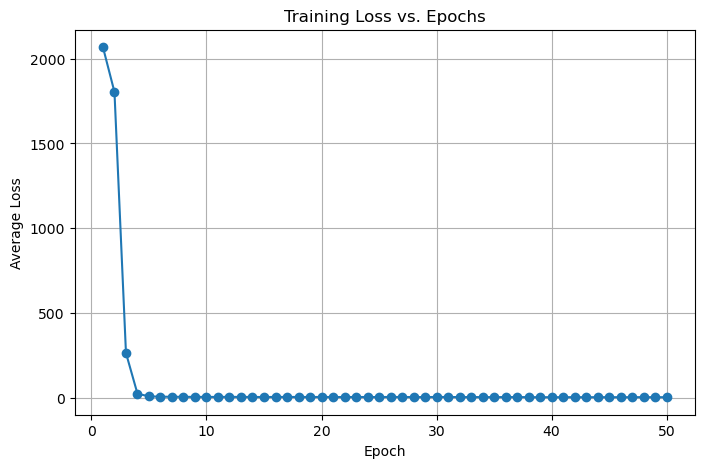

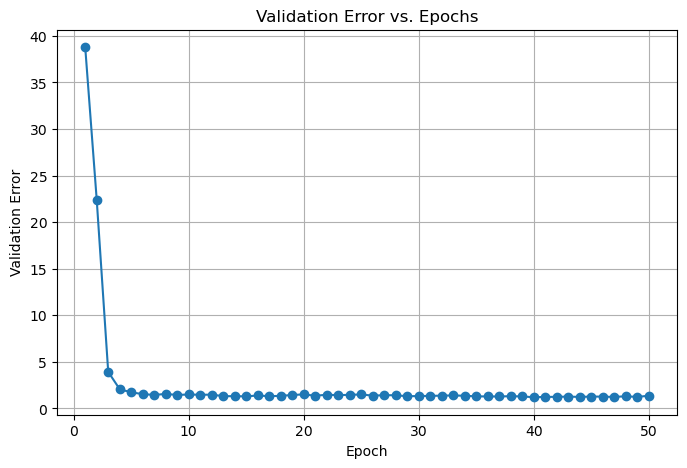

In [31]:
bins_factor = trainloader.dataset.quantization / trainloader.dataset.label_quantization
model = network.SCNN_Tracker3LWAvg(trainset.image_shape, bins_factor=bins_factor).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.start_training(trainloader, optimizer, device, validationloader=testloader, num_steps = 20, num_epochs=50)

In [32]:
network.save_model(model)

Model saved at models/Tracker3LWAvg_q4_20ts_50e.pt


In [23]:
model = network.SCNN_TrackerRegression(trainset.image_shape).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.start_training(trainloader, optimizer, device, validationloader=testloader, num_steps = 20, num_epochs=50)

Flattened feature size: 3840
Pred x and y torch.Size([50, 1]) torch.Size([50, 1])
Labels x and y torch.Size([50]) torch.Size([50])
Pred x and y torch.Size([50, 1]) torch.Size([50, 1])
Labels x and y torch.Size([50]) torch.Size([50])
Pred x and y torch.Size([50, 1]) torch.Size([50, 1])
Labels x and y torch.Size([50]) torch.Size([50])
Pred x and y torch.Size([50, 1]) torch.Size([50, 1])
Labels x and y torch.Size([50]) torch.Size([50])


KeyboardInterrupt: 

Error at 1 timesteps: 19.104798187798824
Error at 2 timesteps: 14.138518409151025
Error at 3 timesteps: 7.599768206884345
Error at 4 timesteps: 3.849987609437463
Error at 5 timesteps: 2.2323535524762947
Error at 6 timesteps: 1.4716938998528932
Error at 7 timesteps: 1.1281001243809838
Error at 8 timesteps: 1.0007680348690005
Error at 9 timesteps: 0.9215078932277891
Error at 10 timesteps: 0.8757732236696977
Error at 11 timesteps: 0.866839331053713
Error at 12 timesteps: 0.8692427247375516
Error at 13 timesteps: 0.8517032893331611
Error at 14 timesteps: 0.8450216206417175
Error at 15 timesteps: 0.8439416792514466
Error at 16 timesteps: 0.8434815805706982
Error at 17 timesteps: 0.8486568802016434
Error at 18 timesteps: 0.8536009720305489
Error at 19 timesteps: 0.8507634113233112


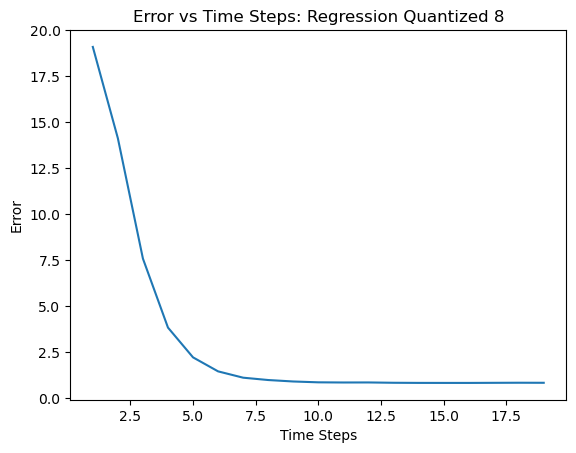

In [28]:
network.plot_timestep_curve(model, testloader, device, identifier="Regression Quantized 8", regression=True, interval = [1, 20, 1])

In [12]:
model = network.SCNN_TrackerRegression(trainset_quant.image_shape).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
network.training_loop_images(model, trainloader, optimizer, device, loss_function=network.regression_loss, validationloader=testloader, num_steps = 20, num_epochs=50, plot=True)

Flattened feature size: 3840
Epoch 1/50, Loss: 540.3165, Validation Error: 19.4436 pixels
Epoch 2/50, Loss: 499.2791, Validation Error: 16.2137 pixels
Epoch 3/50, Loss: 226.8367, Validation Error: 6.8104 pixels
Epoch 4/50, Loss: 57.8182, Validation Error: 3.5018 pixels
Epoch 5/50, Loss: 22.7714, Validation Error: 2.6071 pixels
Epoch 6/50, Loss: 16.9096, Validation Error: 2.3862 pixels
Epoch 7/50, Loss: 10.5857, Validation Error: 2.1805 pixels
Epoch 8/50, Loss: 7.3148, Validation Error: 1.7339 pixels


KeyboardInterrupt: 